## Кейс - определение ССЗ

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [2]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [3]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'), 
                                                    df['cardio'], random_state=1234)

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    '''
    Трансформер для выбора одной колонки из датафрейма для трансформации
    '''
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.key]
    

class NumberSelector(BaseEstimator, TransformerMixin):
    '''
    Трансформер для выбора вещественной колонки из датафрейма для трансформации
    '''
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[[self.key]]
    

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []
        
    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self
    
    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    

In [5]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo'] # Вещ. колонки
cat_cols = ['gender', 'cholesterol'] # Категориальные фичи
base_cols = ['gluc', 'smoke', 'alco', 'active'] # бинарные фичи

In [7]:
continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transformer = Pipeline([
        ('selector', NumberSelector(key=cont_col)),
        ('standart', StandardScaler())
    ])
    continuos_transformers.append((cont_col, transformer))
    
for cat_col in cat_cols:
    transformer = Pipeline([
        ('selector', ColumnSelector(key=cat_col)),
        ('OHE', OHEEncoder(key=cat_col))
    ])
    cat_transformers.append((cat_col, transformer))
    
for base_col in base_cols:
    transformer = Pipeline([
        ('selector', NumberSelector(key=base_col))
    ])
    base_transformers.append((base_col, transformer))
    

In [8]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)

feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)


array([[-1.10731706,  1.17399922,  0.47310859, ...,  1.        ,
         0.        ,  1.        ],
       [-1.29060327, -0.53310392,  1.86546924, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.34701885,  0.07657577,  0.68196269, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.10690352,  1.17399922,  0.12501843, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38324896, -0.53310392, -1.40657828, ...,  1.        ,
         0.        ,  1.        ],
       [ 1.6019202 ,  1.05206328,  0.61234466, ...,  0.        ,
         0.        ,  0.        ]])

Пусть:

- стоимость лечения 15000р, если сделали тест и начали лечить вовремя
- стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
- стоимость теста 1400р



- лишних тестов сделали FP = cnf_matrix[0][1]
- пропустили больных FN = cnf_matrix[1][0]
- правильных тестов сделали TP = cnf_matrix[1][1]

Оценим расходы, если не делать тест и ждать симптомов:

In [10]:
def business_threshold_calibrate(y_test, y_score, thresholds,
                                 rubl_test=100, rubl_early_treatment=100, rubl_late_treatment=1000):
    business_threshold = 0
    r_test_all_r_ML_ = 0

    rubl_ML_ = 1_000_000_000 

    rs = []
    n = 20
    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        rubl_1 = (TP + FN) * rubl_late_treatment
        rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment
        rubl_ML = (TP + FP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
        
        r_test_all_r_ML = rubl_test_all - rubl_ML 
        
        if rubl_ML < rubl_ML_:            
            business_threshold = opt_buisness_tr
            
            rubl_ML_ = rubl_ML
            
        rs.append(rubl_ML)   
            
    print("\nРасходы с оптимальной бизнес метрикой")
    print('Расходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML_)
    print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
    print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML_)
    
    plt.title('Потери при МЛ решении')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0,1,n), rs)
    plt.show()
    return business_threshold

In [12]:
def test_model(model, X_train, y_train, X_test, y_test, model_name=None):
    '''
    Функция пробует модель и выводит нужные метрики
    model_name: {'rf', 'gb', 'logreg'}
    '''
    print(f'\n{model}\n')
    
    classifier = Pipeline([
        ('features', feats),
        ('classifier', model),
    ])

    # запустим кросс-валидацию
    cv_scores = cross_val_score(model, X_train, y_train, cv=7, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print(f'CV score is {cv_score}+-{cv_score_std}\n')

    # обучим пайплайн на всем тренировочном датасете
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)[:, 1]
    
    b = 1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}\n')
    
    print(f"Train roc auc score: {roc_auc_score(y_train, classifier.predict_proba(X_train)[:, 1])}")
    print(f"Test roc auc score: {roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])}\n")
    
    # мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
    font = {'size' : 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                          title='Confusion matrix')
    plt.savefig(f"conf_matrix_{model_name}.png")
    plt.show()
    
    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]

    TPR = TP / (TP+FN)
    FPR = FP / (FN+TN)
    TNR = TN / (FP+TN)
    print(f'TPR = {TPR}\nFPR = {FPR}\nTNR = {TNR}')
    
    rubl_test = 1400
    rubl_early_treatment = 15000
    rubl_late_treatment = 20000

    rubl_1 = (FN + TP) * rubl_late_treatment
    rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment
    rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
    
    print('\nРасходы с оптимальной DS-метрикой')
    print('Расходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML)
    print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
    print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML)
    print('\n')
    
    
    return y_score, thresholds[ix]

## RandomForestClassifier


RandomForestClassifier(max_depth=3, random_state=42)

CV score is 0.7890427121734215+-0.004567514552962378

Best Threshold=0.4062319003828128, F-Score=0.732, Precision=0.647, Recall=0.843

Train roc auc score: 0.7893252351739053
Test roc auc score: 0.7866707711412193

Confusion matrix, without normalization
[[4853 3990]
 [1356 7301]]


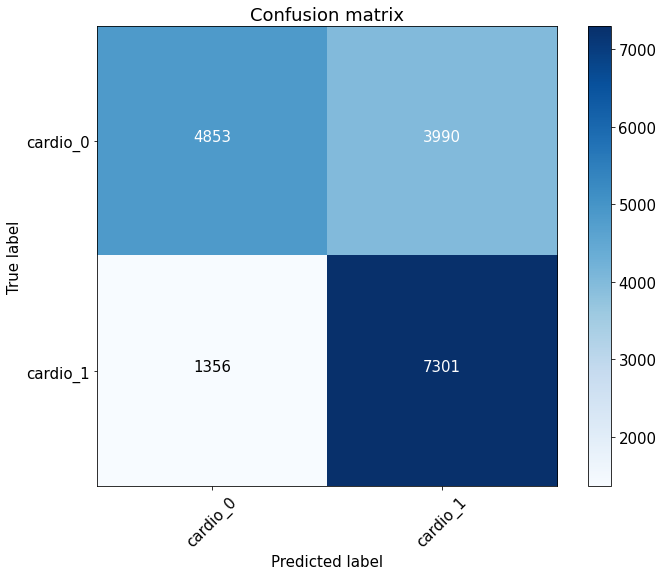

TPR = 0.8433637518770937
FPR = 0.6426155580608793
TNR = 0.5487956575822684

Расходы с оптимальной DS-метрикой
Расходы "решение не делать тесты - расходы с МL:" 20697600
Расходы "решение не делать тесты - расходы сделать тесты всем": 18785000
Расходы "сделать тесты всем - решение делать тесты ML": 1912600




In [13]:
y_score_rf, threshold_rf = test_model(RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42), X_train, y_train, X_test, y_test, 'rf')


Расходы с оптимальной бизнес метрикой
Расходы "решение не делать тесты - расходы с МL:" 20703600
Расходы "решение не делать тесты - расходы сделать тесты всем": 18785000
Расходы "сделать тесты всем - решение делать тесты ML": 1918600


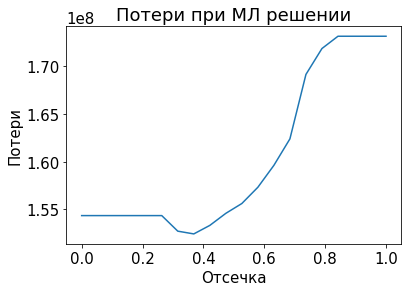

уровень порога по бизнес метрике 0.3684210526315789
уровень порога по f1 метрике 0.4062319003828128


In [14]:
busines_tr = business_threshold_calibrate(y_test, y_score_rf, 
                                          threshold_rf,
                                          rubl_test=1400, 
                                          rubl_early_treatment=15000, 
                                          rubl_late_treatment=20000)

print('уровень порога по бизнес метрике', busines_tr)
print('уровень порога по f1 метрике', threshold_rf)

## GradientBoostingClassifier


GradientBoostingClassifier(n_estimators=200, random_state=42)

CV score is 0.8025959117598136+-0.0035340986512054106

Best Threshold=0.3435122829469178, F-Score=0.740, Precision=0.659, Recall=0.843

Train roc auc score: 0.811440393298139
Test roc auc score: 0.8015971724270279

Confusion matrix, without normalization
[[5061 3782]
 [1360 7297]]


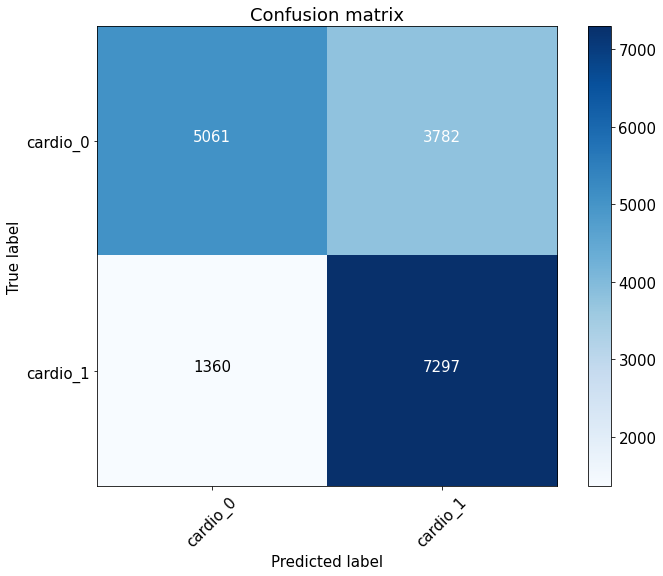

TPR = 0.8429016980478226
FPR = 0.5890048279084255
TNR = 0.5723170869614385

Расходы с оптимальной DS-метрикой
Расходы "решение не делать тесты - расходы с МL:" 20974400
Расходы "решение не делать тесты - расходы сделать тесты всем": 18785000
Расходы "сделать тесты всем - решение делать тесты ML": 2189400




In [15]:
y_score_gb, threshold_gb = test_model(GradientBoostingClassifier(n_estimators=200, random_state=42), X_train, y_train, X_test, y_test, 'gb')


Расходы с оптимальной бизнес метрикой
Расходы "решение не делать тесты - расходы с МL:" 21134000
Расходы "решение не делать тесты - расходы сделать тесты всем": 18785000
Расходы "сделать тесты всем - решение делать тесты ML": 2349000


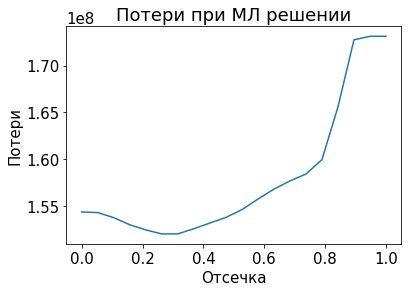

уровень порога по бизнес метрике 0.2631578947368421
уровень порога по f1 метрике 0.3435122829469178


In [17]:
busines_tr = business_threshold_calibrate(y_test, y_score_gb, 
                                          threshold_gb,
                                          rubl_test=1400, 
                                          rubl_early_treatment=15000, 
                                          rubl_late_treatment=20000)

print('уровень порога по бизнес метрике', busines_tr)
print('уровень порога по f1 метрике', threshold_gb)

## LogisticRegression


LogisticRegression(max_iter=1000, random_state=42)

CV score is 0.7545825947678153+-0.004842072618404077

Best Threshold=0.3987651061707421, F-Score=0.732, Precision=0.649, Recall=0.840

Train roc auc score: 0.7825299499468632
Test roc auc score: 0.7847753864139374

Confusion matrix, without normalization
[[4906 3937]
 [1388 7269]]


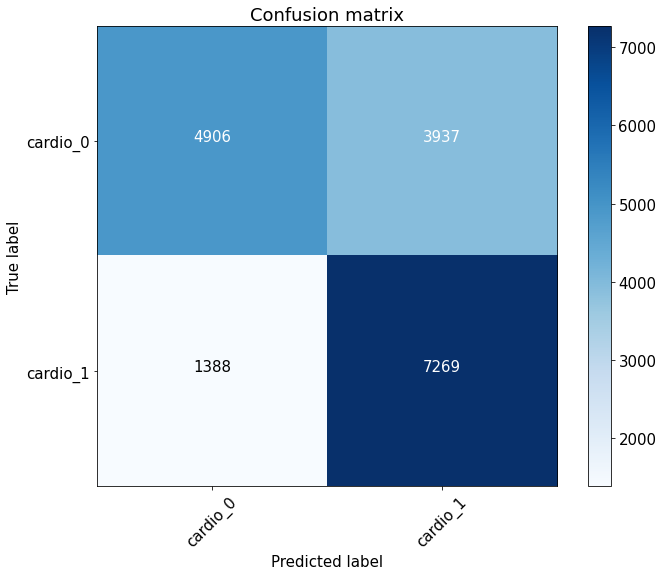

TPR = 0.8396673212429248
FPR = 0.6255163647918652
TNR = 0.5547890987221531

Расходы с оптимальной DS-метрикой
Расходы "решение не делать тесты - расходы с МL:" 20656600
Расходы "решение не делать тесты - расходы сделать тесты всем": 18785000
Расходы "сделать тесты всем - решение делать тесты ML": 1871600




In [18]:
y_score_lr, threshold_lr = test_model(LogisticRegression(max_iter=1000, random_state=42), X_train, y_train, X_test, y_test, 'lr')


Расходы с оптимальной бизнес метрикой
Расходы "решение не делать тесты - расходы с МL:" 20879200
Расходы "решение не делать тесты - расходы сделать тесты всем": 18785000
Расходы "сделать тесты всем - решение делать тесты ML": 2094200


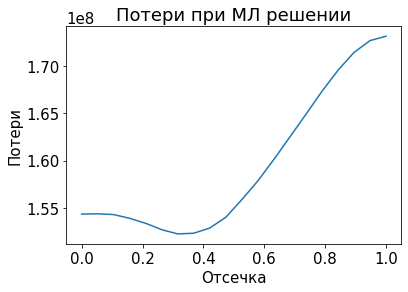

уровень порога по бизнес метрике 0.3157894736842105
уровень порога по f1 метрике 0.3987651061707421


In [20]:
busines_tr = business_threshold_calibrate(y_test, y_score_lr, 
                                          threshold_lr,
                                          rubl_test=1400, 
                                          rubl_early_treatment=15000, 
                                          rubl_late_treatment=20000)

print('уровень порога по бизнес метрике', busines_tr)
print('уровень порога по f1 метрике', threshold_lr)

**Вывод лучшее качество показывает GradientBoostingClassifier как DS метрика так и бизнес показатели выше, чем у других**